# 7주차: Deep Learning Framework

13기 조상연

### 과제: Kannada MNIST (https://www.kaggle.com/c/tobigs13nn)

데이터: Train: 42,000 rows, Test: 18,000 rows

### 목차

1. 데이터 전처리
2. 여러 딥러닝 심화 기법 비교 (with Hiplot)

    - Activation
        - Relu / Leaky Relu / PRelu
        - Softmax
    - Batch Norm
    - Weight Init
    - Optimizer
        - Rmsprop, Adam, Radam
    - Regularzation
       - Dropout,  Spatial Dropout
       - Early Stopping
       - Data Augmentation
3. 모델 리서치 및 선정
    1. VGG (https://www.kaggle.com/benanakca/kannada-mnist-cnn-tutorial-with-app-top-2)
    2. SOPCNN (https://paperswithcode.com/paper/stochastic-optimization-of-plain)
4. 학습 및 하이퍼 파라미터 조정

# 0. Pre-requisite & Module Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 현재 폴더 위치로 이동
cd drive/My Drive/Colab Notebooks/week7

/content/drive/My Drive/Colab Notebooks/week7


In [ ]:
!pip install tensorflow-gpu==2.1.0 # Keras Data Augmentation 툴 이용시 필요, 그냥 tf 2.0으로 하면 에러
# !pip install autokeras
# !pip install hiplot
# !pip install kaggle

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x # Colab에서 텐서플로우 2.0을 사용할 수 있는 Magic Method
except Exception:
    pass
import tensorflow as tf

import os
import tensorflow_datasets as tfds

TensorFlow 2.x selected.


In [ ]:
%load_ext tensorboard

In [8]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D, LeakyReLU, ReLU, PReLU
from tensorflow.keras.optimizers import RMSprop, Nadam, Adadelta, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [ ]:
!ls ~/.kaggle/

In [ ]:
# Kaggle API Key to Root
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os

def save_and_submit(model, filename, description):
    """
    CSV파일 저장 후 Kaggle로 전송
    """
    if "predict_classes" in dir(model):
        predict = model.predict_classes(X_test)
    else:
        # Predict_classes 함수가 없는 경우 predict 후 argmax 로 predict 생성
        predict = np.argmax(model.predict(X_test), axis=1)
    
    sample_submission['Category'] = predict
    sample_submission.to_csv(filename,index=False)
    
    # system 함수로 kaggle 명령어 실행
    os.system(f"kaggle competitions submit -c tobigs13nn -f {filename} -m {description}")

In [3]:
import glob
glob.glob("*")

['w7_pytorch.ipynb',
 'test_df.csv',
 'Untitled.ipynb',
 'FirePytorch.ipynb',
 'w7_DL_Framework.ipynb',
 'FireKeras.ipynb',
 'tutorial-for-everybody.ipynb',
 'grid_result.json',
 'train_df.csv',
 'sample_submission.csv']

In [ ]:
# GPU 셋팅 확인
tf.test.gpu_device_name()

'/device:GPU:0'

# 1. Data Load & Preprocessing

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
test = pd.read_csv("test_df.csv")
train = pd.read_csv("train_df.csv")

print(f"Train data shape {train.shape}")
print(f"Test data shape {test.shape}")

X = train.iloc[:,1:].values
y = train.iloc[:,0].values
X_test = test.iloc[:,1:].values


X = X / 255
X_test = X_test / 255

# 이미지로 처리하기 위해 변환
X = X.reshape(-1, 28, 28,1)
X_test = X_test.reshape(-1, 28, 28,1)

y = to_categorical(y)

Train data shape (42000, 785)
Test data shape (18000, 785)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42) 

In [ ]:
# 데이터 크기 확인
x_train.shape, x_val.shape, X_test.shape

((33600, 28, 28, 1), (8400, 28, 28, 1), (18000, 28, 28, 1))

#  2. 딥러닝 심화 기법 Grid Search (with Hiplot) 

> 다양한 기법과 하이퍼 파라미터 튜닝을 통해 각 기법 들의 효과를 정리


``` python
param_grid = {
    'batch_size': [512, 1024, 2048],
    'epochs': [20],
    '_optimizer': ['RMSprop','Adam'], 
    '_lr': [1e-3, 2e-3, 1e-2], 
    '_batch_norm': [1, 0], 
    '_activation': ['relu'],
    '_dropout': [0.2, 0.4], 
}
```

이번에 배운 여러가지 기법들의 유/무,크기 조절 등을 통해 그 효과를 분석하고 가장 최적의 파라미터를 구해본다.<br>
파라미터별로 최소 3개에서 5개까지 옵션을 주고 싶었지만 Colab 메모리가 감당하지 못하고 계속 터져서 가능한 수준으로 낮추었다.

## 2.1 Grid Search 준비 및 모델 생성

In [ ]:
# 이전에 배운 scikit-learn의 GridSearchCV와 KerasClassifier 이용
import numpy
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(_optimizer, _lr, _batch_norm, _activation, _dropout):
    """
    기법 간 비교를 위한 모델 생성 (FC 3-Layer)
    """
    model = tf.keras.models.Sequential()
    model.add(Dense(64, input_shape=(784,)))
    model.add(BatchNormalization())  if _batch_norm else '' # batch_norm 유/무 결정
    model.add(Dropout(_dropout))

    model.add(Dense(128, activation=_activation))
    model.add(BatchNormalization())  if _batch_norm else '' # batch_norm 유/무 결정
    model.add(Dropout(_dropout))

    model.add(Dense(256, activation=_activation))
    model.add(BatchNormalization())  if _batch_norm else '' # batch_norm 유/무 결정
    model.add(Dropout(_dropout))

    model.add(Dense(10, activation='softmax'))

    optimizer = getattr(tf.keras.optimizers, _optimizer)(learning_rate=_lr)

    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

    return model

# KerasClassifier로 모델 생성기 설정
model = KerasClassifier(build_fn=create_model, verbose=3)

In [ ]:
# Grid 설정
param_grid = {
    'batch_size': [1024, 2048],
    'epochs': [15, 30],
    '_optimizer': ['RMSprop','Adam'], 
    '_lr': [1e-3, 2e-3, 1e-2], 
    '_batch_norm': [1, 0], 
    '_activation': ['relu'],
    '_dropout': [0.2, 0.4], 
}

In [ ]:
param_grid

{'batch_size': [2048],
 'epochs': [15, 30],
 '_optimizer': ['RMSprop', 'Adam'],
 '_lr': [0.001, 0.01],
 '_batch_norm': [True, False],
 '_activation': ['relu'],
 '_dropout': [0.2, 0.4]}

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X, y) #Grid Search 학습
grid_result

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f61b1e6b6d8>,
             iid='deprecated', n_jobs=None,
             param_grid={'_activation': ['relu'], '_batch_norm': [True, False],
                         '_dropout': [0.2, 0.4], '_lr': [0.001, 0.01],
                         '_optimizer': ['RMSprop', 'Adam'],
                         'batch_size': [2048], 'epochs': [15, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grid_result.cv_results_['rank_test_score'] # 테스트 Score 순위
grid_result.cv_results_['mean_test_score'] # 테스트 Score 평균
grid_result.cv_results_['std_test_score'] # 테스트 Score std

array([0.00191339, 0.00231553, 0.00210279, 0.0021028 , 0.00749656,
       0.00113289, 0.00187718, 0.00275614, 0.0021762 , 0.00204734,
       0.00289577, 0.00242509, 0.0027911 , 0.00478707, 0.00220003,
       0.00271803, 0.00134518, 0.00207868, 0.00301714, 0.00154302,
       0.00933254, 0.00683188, 0.00201384, 0.0019293 , 0.00253702,
       0.00236972, 0.00268085, 0.00193342, 0.00889858, 0.01590848,
       0.0020548 , 0.00267833])

In [ ]:
# 시각화를 위한 전처리
grid_params = grid_result.cv_results_['params']
for i in range(len(grid_params)):
    for key in ['mean_test_score', 'std_test_score', 'mean_fit_time']:
        grid_params[i][key] = grid_result.cv_results_[key][i]

In [ ]:
import json

In [ ]:
# grid_params 결과 저장
with open('grid_result.json','w') as f:
    f.write(json.dumps(grid_params))

In [11]:
# grid_params 결과 불러오기
with open('grid_result2.json','r') as f:
    grid_params = json.loads(f.read())

In [28]:
# grid_params

## 2.2 결과 시각화

> 시각화로 Facebook Research의 Hiplot( https://github.com/facebookresearch/hiplot )을 사용하였다. 
> 
> 특히 고차원의 데이터 간의 패턴을 보기에 용이하다고 한다.


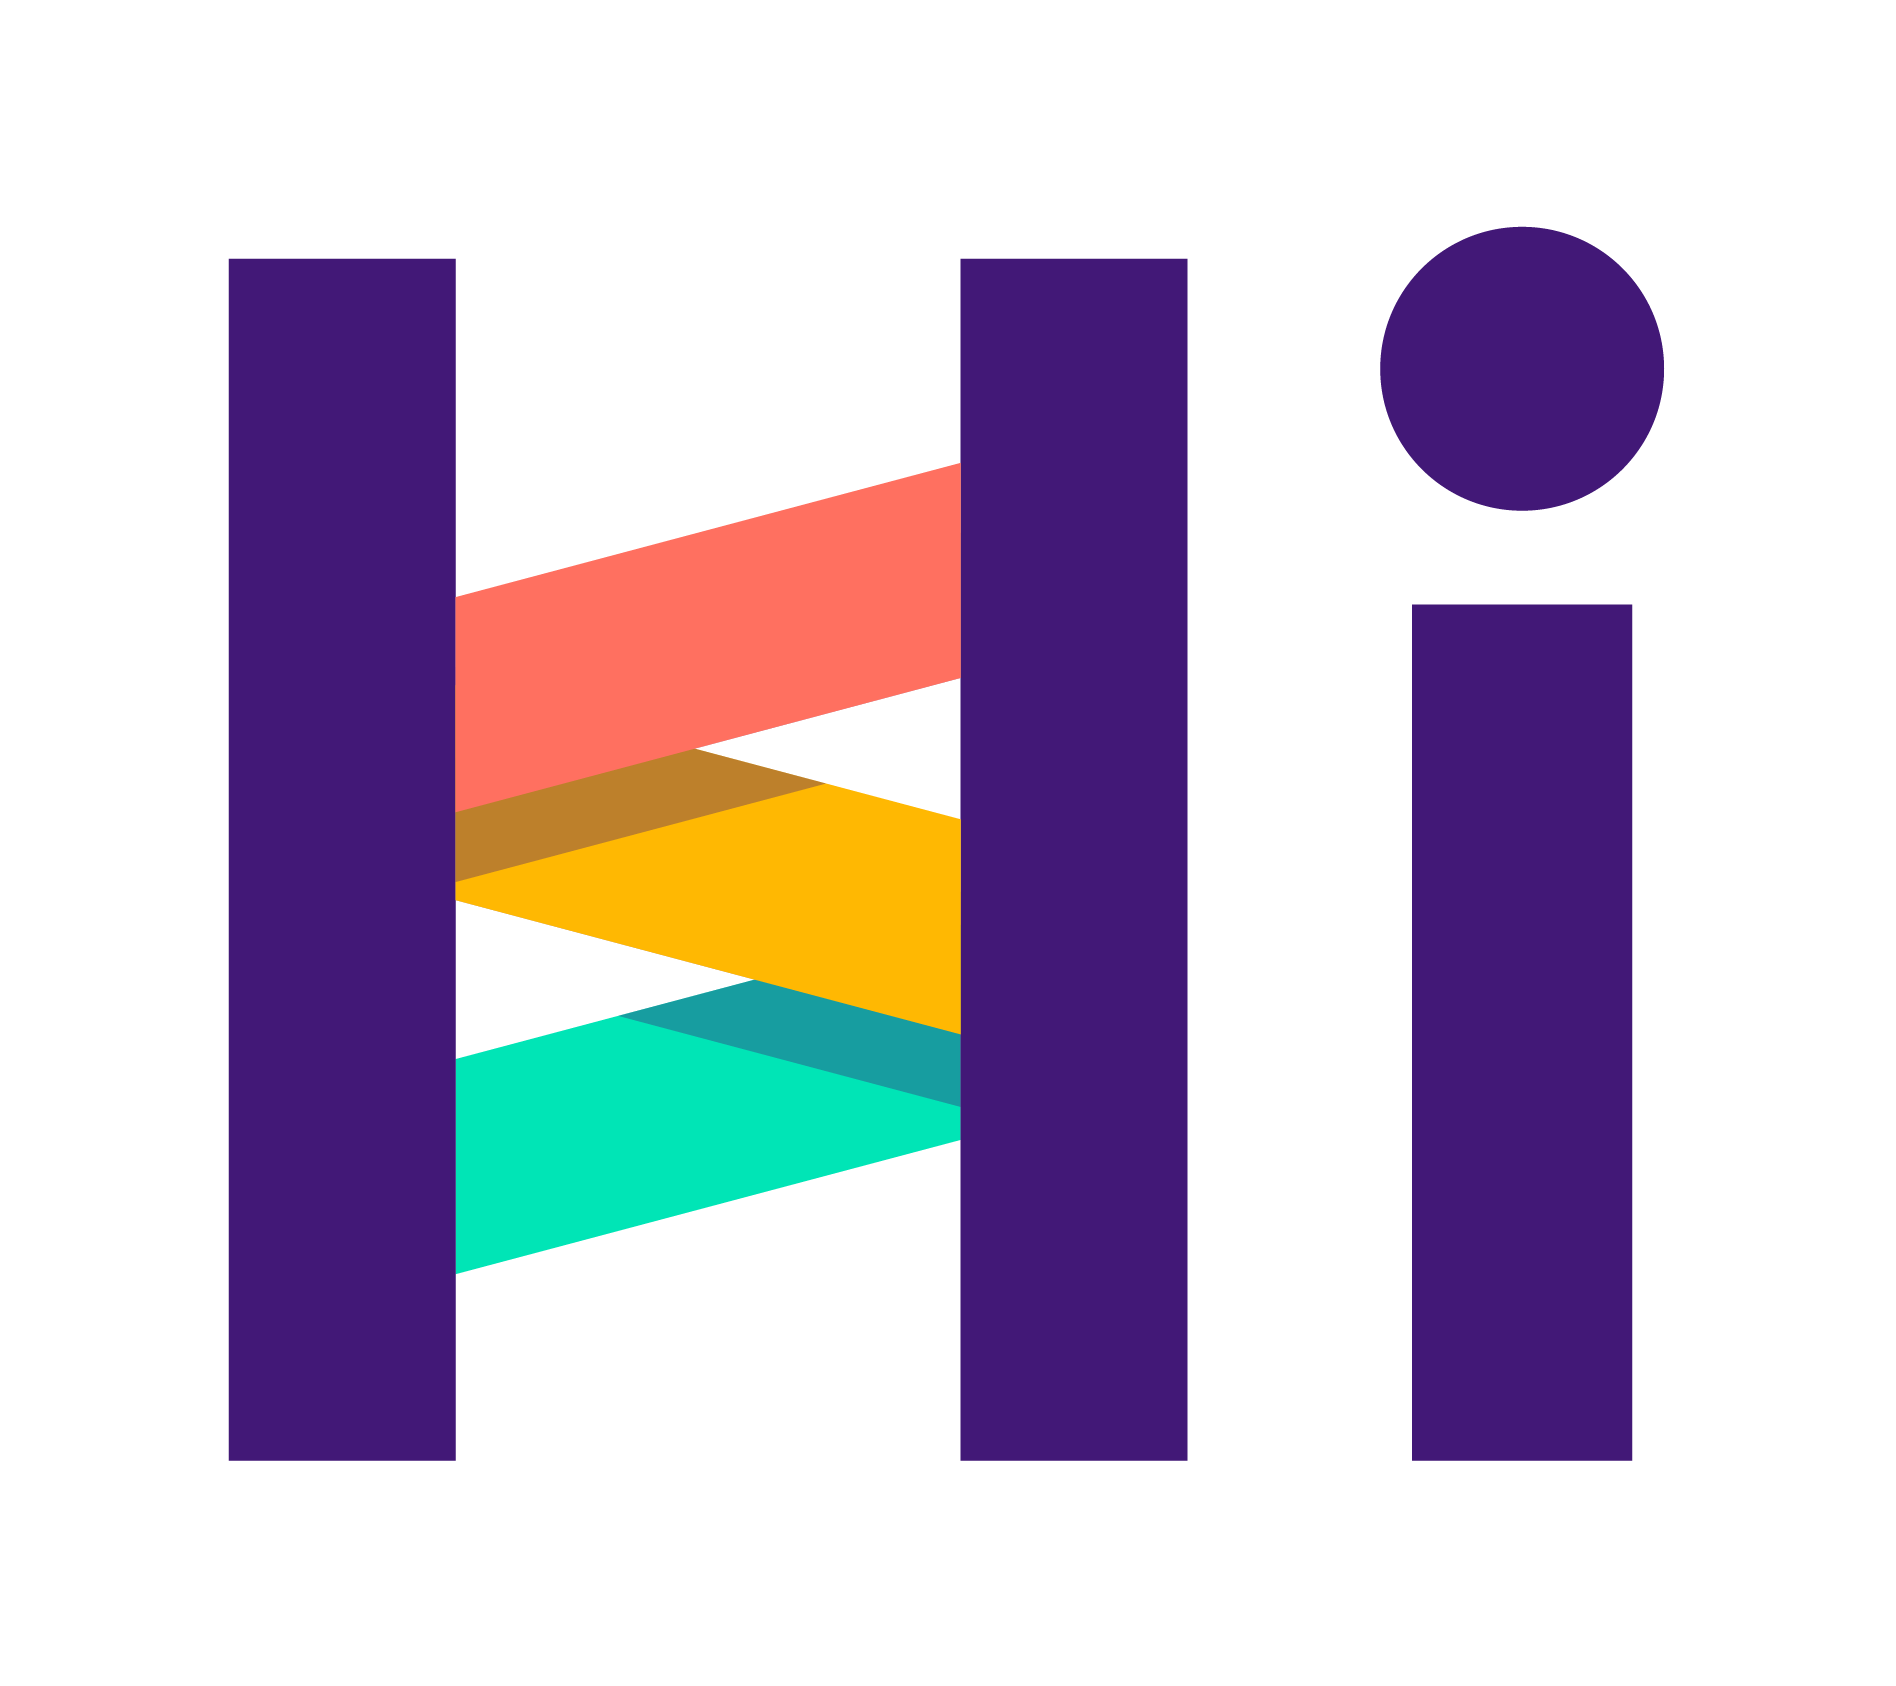

<IPython.core.display.Javascript object>

In [12]:
import hiplot as hip
hip.Experiment.from_iterable(grid_params).display()

![aa](hiplot2.png)

**전체 그래프**

![aa](hiplot1.png)

**mean_score, Std_score 상위 모델 그래프**

### 인사이트 

1. 확실히 **최상위권의 모델엔 BatchNorm이 거의 모두 적용되어 있다.**

2. Dropout은 **0.2에서 좋은 성능**을 보였다.

3. Lr은 0.01이 좋게 나왔지만, 이는 Epoch이 20 밖에 안되어 아직 학습이 진행 중일 가능성이 크다.

4. **Batch Size는 낮을 수록 좋은 성능이 나왔다.** 완전 비례라 보긴 힘들겠지만 논문에서도 256을 적용한 것을 보면 너무 크면 각 Batch의 특성이 뭉개지는게 아닐까 추측된다.

5. Optimizer는 Adam과 RMSprop 모두 괜찮은 성능이 나왔다.

# 3. Model Research & Selection

MNIST 데이터셋은 대표적인 이미지 분류 데이터셋으로 많은 딥러닝 모델이 SOTA급 성능을 보여주고 있다. 

그중에서 특히 CNN 모델이 빠른 학습 속도와 월등한 성능을 보여주고 있으며 이번 과제의 전신인 Kannada MNIST에서도 많은 사람들이 해당 모델을 통해 좋은 성적을 거두었다. 이를 참고하여 모델을 설계하고, Papers with code 에서 SOTA급 논문 들을 참고하여 여러 기법 들의 장단점을 참고하여 적용해본다. 그리고 실제로 꽤 좋은 인사이트를 얻을 수 있었다.


## 3.1 SOPCNN

> Stochastic Optimization of Plain Convolutional Neural Networks with Simple methods
>
> 2020 MNIST SOTA

- [Arxiv 논문 링크](https://arxiv.org/pdf/2001.08856v1.pdf)
- [MNIST SOTA 리스트 2위](https://paperswithcode.com/sota/image-classification-on-mnist)

MNIST 2020년 SOTA인 SOPCNN 논문을 보면, 최적화 기법에 상당히 공을 들였음을 알 수 있고 특히 이번 내용과 겹치는 부분이 가져와 적용해보면 좋을 점이 많았다. 이 논문이 지향하는 바는 CNN모델이 좋은 성능을 보이지만 epoch이 증가함에 따른 overfitting 문제가 심하여 이를 어떻게 잘 최적화할지로 Data Augmentation과 특히 Dropout을 주로 다루고 있다. 


### Architecture and Design
기본적 모델 구성은 [SimpleNet](https://github.com/Coderx7/SimpleNet)의 구성을 따르고 있다고 한다. MNIST 모델을 예를 들면, 총 4개의 Conv2D layer 가 있고 2개 마다 Max Pooling Layer가 붙는다. 뒤이어 2개의 Fully Connected Layer, 마지막엔 Softmax Activation Layer를 붙여 모델을 완성시켰다. 여기서 학습률은 0.01로 주었고 Dropout 위치 및 FC Layer의 크기는 파라미터 조정을 통해 결정하였다.


### 가장 인상깊었던 점

1. **Dropout은 Softmax 직전에 하나만 있는 것이 가장 좋다** :Maxpool 뒤에 배치하기도 하고, Spatial Dropout도 적용해보았지만 그냥 Regular Dropout을 FC 다음에 배치한 것이 가장 성능이 좋았다고 한다.
2. **FC Layer 2048, Drop rate 0.8이 가장 좋다**: 왜 이 논문 제목에서 Stochastic이란 말을 썼는지 알 수 있는 대목이다. 믿기지 않는 드롭율이라 5번의 반복 실험을 통해 평균 0.18%의 에러율이 나온다는 것을 입증하였다. 

그 외에도 Data Augmentation 셋팅 등을 소개하고 있어 학습에 참고할 수 있었다.

### 3.1.1 구현

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(2048),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0

> 텐서플로우가 친절하게 Drop rate가 0.5가 넘으니 혹시 과거에서 오신 분인지 여쭙고 있지만 무시하고 학습을 진행해본다.

In [ ]:
optimizer = Adam(learning_rate=0.01) # 논문 설정대로 0.01을 주었다.

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### 3.1.2 학습 및 결과

실제 Colab에서 돌려본 결과 학습이 너무 안되었다. Val_Acc가 0.98에 접근조차 못하고 모델이 전혀 Simple하지 않아 학습에도 오랜시간이 걸렸다.

그 이후로 FC의 하이퍼 파라미터 2048를 1024로, Drop Rate를 0.6, 0.4로 각기 실험해보았을 때 Val Acc 99.6로 비슷하게 높은 성능이 나왔다. 

여기서 **데이터 크기나 분류할 갯수로 FC 파라미터를 좀 더 작게 조정할 필요**가 있다는 것을 알 수 있었으며, 논문에선 Epoch을 2000까지 진행하는데 지금 Colab에서 그건 힘들기 때문에 **Drop rate에서 어느정도 타협을 보아 빠른 학습을 진행**해야 겠다는 방향성을 세울 수 있었다.

 ```
 
 
 ```

## 3.2 CNN (VGG + Data Augmentation)

> https://www.kaggle.com/benanakca/kannada-mnist-cnn-tutorial-with-app-top-2

https://www.kaggle.com/c/Kannada-MNIST 에서 상위 2%의 성능이 나온 모델을 찾을 수 있었고 친절하게 여러 기법들을 소개하고 있었다.

그 중에서 특히 ImageDataGenerator와 ReduceLROnPlateau이 인상적이였는데 전자는 이미지 데이터를 랜덤으로 변화시켜 기존 데이터에 Overfitting되는 것을 방지하기 위한 Data Augmentation툴로 tf.keras에서 불러올 수 있다. 후자는 그 뜻대로 안정되면 학습률을 낮춰주는 콜백함수로 학습 중에 지표를 계속 모니터링 하여 일정 수준 이상 안정이 되면 factor * lr로 현재의 학습률을 순차적으로 낮추어 min_lr에 근접하도록 한다. 

주의할 점은 ImageDataGenerator의 파라미터를 숙지하여 혹시 모를 실수를 방지해야하는 데, 특히 Mnist의 경우 flip이 일어나선 안되며 cutout도 지양한다. 

아래 표는 SOPCNN에서 진행한 Data Augmentation 이다.

|technique Use||
|--|--|
|rotation|Only used with mnist|
|shearing |Yes|
|Shifting up and down|Yes|
|Zooming |Yes|
|rescale |Yes|
|cutout |No|
|flipping| No|

In [ ]:
datagen_train = ImageDataGenerator(rotation_range = 10, 
                                   # 360도 기준으로 정수형을 넣어야한다. 10 -> 10도안에서 회전
                                   width_shift_range = 0.25, 
                                   # 1을 기준으로 0.25만큼 가로 이동, 1보다 크다면 이동 픽셀수로 변환
                                   height_shift_range = 0.25, 
                                   # 위와 같음
                                   shear_range = 0.1,  
                                   # 휘어짐 정도
                                   zoom_range = 0.4,
                                   # 확대 정도, 이 경우 [최소:0.6, 최대:1.4] 을 의미한다. [0.7,1] 이런 식도 가능
                                   horizontal_flip = False) 
# 수평 뒤집기 False로 방지, 하지만 이미 default가 False라 굳이 할 필요는 없다.

datagen_val = ImageDataGenerator() 

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau( 
    monitor='loss',    
    # Quantity to be monitored.
    factor=0.25,       
    # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=2,        
    # The number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,         
    # 0: quiet - 1: update messages.
    mode="auto",       
    # {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; 
    # in the max mode it will be reduced when the quantity monitored has stopped increasing; 
    # in auto mode, the direction is automatically inferred from the name of the monitored quantity.
    min_delta=0.0001,  
    # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,        
    # number of epochs to wait before resuming normal operation after learning rate (lr) has been reduced.
    min_lr=0.00001     
    # lower bound on the learning rate.
    )

### 3.2.1 모델링

> VGG와 유사한 모형을 하고 있으며 Conv2D(512) Layer는 제거한 후 flatten후 FC(256)만 주었다는 게 특징이다.
>
> 은닉층은 모두 LeakyReLU를 사용하였다. 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),    
    
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),##
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),
 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = RMSprop(learning_rate=0.002,
    rho=0.9,
    momentum=0.1,
    epsilon=1e-07,
    centered=True,
    name='RMSprop')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

history = model.fit(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=epochs,
                              validation_data=(x_val, y_val),
                              callbacks=[learning_rate_reduction, es],
                              verbose=2)

Colab에서 Epoch 40만큼 학습시킨 결과 Acc 99.74란 결과가 나왔다. 매우 좋은 결과라 이 모델과 여러 기법을 적용하여 하이퍼 파라미터 튜닝을 진행하였다.

# 4. 학습 및 하이퍼 파라미터 조정

> VGG 모델에 바탕을 두고 여러 최적화 기법을 적용하였다. Conv레이어 추가, Relu로 바꾸기, FC Layer 조정, Dropout 조정 등을 해보았다.
>
> Pytorch에선 Transformer 모델도 실험해보았지만 성능이 별로 좋지 않았다. (0.96)

결과적으로 **SOPCNN와 VGG를 적절히 혼합한 모델**이 가장 성능이 좋았다.

1. **마지막에만 Dropout**: 이때 Drop-rate 0.2 ~ 0.6 까지 다양하게 주었을 때 0.25가 가장 괜찮은 성능을 보였다.
2. **Conv2D(512) 하나 추가**: 기존 VGG에서 4개가 쌓이지만 데이터 크기와 이미지 크기를 고려했을 때 하나만 추가하는 것이 가장 나은 성능을 보였다.
3. **FC Layer 1024**: 256 ~ 2048(sopcnn) ~ 4096(vgg) 모두 해보았을 때 1024가 가장 좋은 성능을 보였다.
4. Epoch을 충분히 주고 Early Stopping으로 최선의 모델을 찾는 것이 좋다. 

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    #  기존의 Dropout 삭제
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    #  기존의 Dropout 삭제
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),##
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #  Conv2D 512 추가
    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),##
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(10, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_25 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 64)       

### 결과 및 느낀점

아직 모델이 깊지 않아 그런 것 같지만 좋은 모델은 처음부터 loss 떨어지는 게 다르다. 좋은 모델일 수록 epoch 10 안쪽에서 빠르게 Val_Acc가 좋게 나와 이후를 가늠해볼 수 있었다. 물론 epoch을 2000정도로 두고 깊게 학습시킨다면 좋겠지만 한정된 자원에서 그나마 나은 모델을 골라내기 위한 최선이 아닐까 싶다. 이 모델의 경우 epoch 8에서 0.99의 val_acc를 보이고 중간 중간 0.998를 상회하기도 하였다. 

그리고 알게된 것이 keras layer의 기본 kernel weight initializer가 xavier라는 것을 알게되었다. 좀 더 GPU 자원이 허락했다면 weight initializer도 바꿔보고 batch_size도 더 다양화시킬 수 있지 않을까란 아쉬움이 남는다.

# 번외) Auto Keras

> Automl로 자동으로 모델을 짜주는 시대에서 과연 그 성능은 어떨까

In [ ]:
import autokeras as ak

In [ ]:
print(x_train.shape)  
print(y_train.shape) 

(33600, 28, 28, 1)
(33600, 10)


In [ ]:
# Initialize the ImageClassifier.
clf = ak.ImageClassifier(max_trials=3)

# Search for the best model.
clf.fit(x_train, y_train,
        validation_data=(x_val, y_val), # validation set
        epochs=10)

Train for 1050 steps, validate for 263 steps
Epoch 1/10
1050/1050 [==============================] - 9s 9ms/step - loss: 0.1285 - accuracy: 0.9601 - val_loss: 0.0466 - val_accuracy: 0.9875
Epoch 2/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0476 - accuracy: 0.9849 - val_loss: 0.0360 - val_accuracy: 0.9902
Epoch 3/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0365 - accuracy: 0.9892 - val_loss: 0.0389 - val_accuracy: 0.9894
Epoch 4/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0292 - accuracy: 0.9907 - val_loss: 0.0374 - val_accuracy: 0.9907
Epoch 5/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0287 - accuracy: 0.9907 - val_loss: 0.0326 - val_accuracy: 0.9919
Epoch 6/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0249 - accuracy: 0.9922 - val_loss: 0.0316 - val_accuracy: 0.9895
Epoch 7/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0224 - accura

Train for 1050 steps, validate for 263 steps
Epoch 1/10
1050/1050 [==============================] - 77s 73ms/step - loss: 0.2367 - accuracy: 0.9337 - val_loss: 0.0599 - val_accuracy: 0.9837
Epoch 2/10
1050/1050 [==============================] - 69s 66ms/step - loss: 0.0999 - accuracy: 0.9753 - val_loss: 0.0854 - val_accuracy: 0.9829
Epoch 3/10
1050/1050 [==============================] - 69s 66ms/step - loss: 0.0586 - accuracy: 0.9848 - val_loss: 1.5777 - val_accuracy: 0.8914
Epoch 4/10
1050/1050 [==============================] - 71s 68ms/step - loss: 0.0444 - accuracy: 0.9887 - val_loss: 0.0594 - val_accuracy: 0.9870
Epoch 5/10
1050/1050 [==============================] - 71s 67ms/step - loss: 0.0477 - accuracy: 0.9876 - val_loss: 0.0479 - val_accuracy: 0.9887
Epoch 6/10
1050/1050 [==============================] - 69s 66ms/step - loss: 0.0505 - accuracy: 0.9888 - val_loss: 10.7493 - val_accuracy: 0.6519
Epoch 7/10
1050/1050 [==============================] - 68s 65ms/step - loss: 

Train for 1050 steps, validate for 263 steps
Epoch 1/10
1050/1050 [==============================] - 7s 7ms/step - loss: 0.1271 - accuracy: 0.9611 - val_loss: 0.0507 - val_accuracy: 0.9870
Epoch 2/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0479 - accuracy: 0.9854 - val_loss: 0.0386 - val_accuracy: 0.9898
Epoch 3/10
1050/1050 [==============================] - 7s 6ms/step - loss: 0.0371 - accuracy: 0.9886 - val_loss: 0.0337 - val_accuracy: 0.9911
Epoch 4/10
1050/1050 [==============================] - 7s 6ms/step - loss: 0.0294 - accuracy: 0.9906 - val_loss: 0.0340 - val_accuracy: 0.9906
Epoch 5/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0257 - accuracy: 0.9915 - val_loss: 0.0327 - val_accuracy: 0.9914
Epoch 6/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0331 - val_accuracy: 0.9910
Epoch 7/10
1050/1050 [==============================] - 7s 7ms/step - loss: 0.0215 - accura

INFO:tensorflow:Oracle triggered exit
Train for 1050 steps, validate for 263 steps
Epoch 1/10
1050/1050 [==============================] - 7s 7ms/step - loss: 0.1359 - accuracy: 0.9585 - val_loss: 0.0513 - val_accuracy: 0.9870
Epoch 2/10
1050/1050 [==============================] - 7s 6ms/step - loss: 0.0482 - accuracy: 0.9852 - val_loss: 0.0372 - val_accuracy: 0.9899
Epoch 3/10
1050/1050 [==============================] - 7s 6ms/step - loss: 0.0360 - accuracy: 0.9888 - val_loss: 0.0364 - val_accuracy: 0.9906
Epoch 4/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 0.0340 - val_accuracy: 0.9906
Epoch 5/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0261 - accuracy: 0.9918 - val_loss: 0.0327 - val_accuracy: 0.9917
Epoch 6/10
1050/1050 [==============================] - 7s 6ms/step - loss: 0.0234 - accuracy: 0.9923 - val_loss: 0.0310 - val_accuracy: 0.9924
Epoch 7/10
1050/1050 [==============================]

## 생성된 모델 Summary 및 Sumbit

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
normalization (Normalization (None, 28, 28, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0     

신기하게도 꽤 비슷한 모델을 짰다. 월씬 단순하고 params가 11만 밖에 안되지만 성능은 Public Dashboard 기준 0.9911이 나왔다.

In [ ]:
# Evaluate on the testing data.
print('Accuracy: {accuracy}'.format(
    accuracy=clf.evaluate(x_val, y_val)))

263/263 [==============================] - 1s 4ms/step - loss: 0.0416 - accuracy: 0.9912
Accuracy: [0.04157625054905844, 0.9911905]


In [ ]:
model = clf.export_model() # Auto Keras로 생성된 모델 Export
save_and_submit(model, "autokeras.csv", "AutoKeras_iter3")

## Validation 학습

In [ ]:
model.fit(x_val, y_val, epochs=5, batch_size=1024, verbose=3)
save_and_submit(model, "submit.csv", "AK+val")

Validation Set까지 학습시키니 0.993 으로 성능이 향상되었다.